## Setup


In [2]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q datasets
!pip install -q evaluate
!pip install -q -U accelerate

!pip install -q matplotlib
!pip install -q protobuf==3.20.1
!pip install -q tensorboard

## Imports


In [77]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel, 
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

In [78]:
bold = f"\033[1m"
reset = f"\033[0m"

In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training and Dataset Configurations


In [80]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 8
    EPOCHS:        int = 10
    LEARNING_RATE: float = 2e-5

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = '.'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-handwritten'

## The SCUT Dataset


The SCUT dataset that we are using contains a total of 7703 images. Out of these 6052 are training samples and 1651 are validation samples. Here is the directory structure of the `scut_data` directory after downloading and extracting it.

```
scut_data/
├── scut_train
├── scut_test
├── scut_train.txt
└── scut_test.txt
```


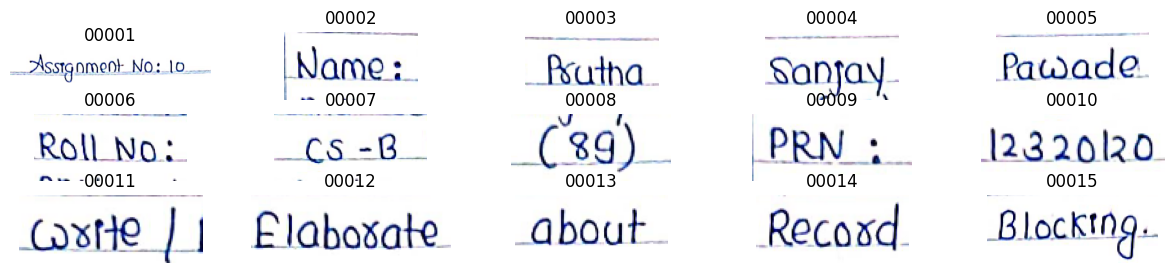

In [81]:
def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        all_images = os.listdir(f"{dataset_path}/data_train")
        image = plt.imread(f"{dataset_path}/data_train/{all_images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(all_images[i].split('.')[0])
    plt.show()

visualize(DatasetConfig.DATA_ROOT)

## Prepare Dataset


In [85]:
# train_df = pd.read_fwf(
#     os.path.join(DatasetConfig.DATA_ROOT, 'custom_train.txt'), header=None
# )
# train_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)
# test_df = pd.read_fwf(
#     os.path.join(DatasetConfig.DATA_ROOT, 'custom_test.txt'), header=None
# )
# test_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)

# using csv files instead of txt files
train_df = pd.read_csv(
    os.path.join(DatasetConfig.DATA_ROOT, 'hand_train.csv')
)

test_df = pd.read_csv(
    os.path.join(DatasetConfig.DATA_ROOT, 'hand_test.csv')
)


In [86]:
train_df.head()

,file_name,text
0,00001.png,Assignemnt No: 10
1,00002.png,Name:
2,00003.png,Prutha
3,00004.png,Sanjay
4,00005.png,Pawade


In [87]:
test_df.head()

,file_name,text
0,00900.png,Assignment
1,00901.png,/
2,00902.png,task
3,00903.png,gets
4,00904.png,reduced


In [88]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(1, 3), sigma=(0.1, 1)),
])

In [89]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['file_name'][idx]
        # The text (label).
        text = self.df['text'][idx]
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [90]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)

train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'data_train/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'data_test/'),
    df=test_df,
    processor=processor
)

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [91]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 828
Number of validation examples: 30


In [92]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


(-0.5, 328.5, 56.5, -0.5)

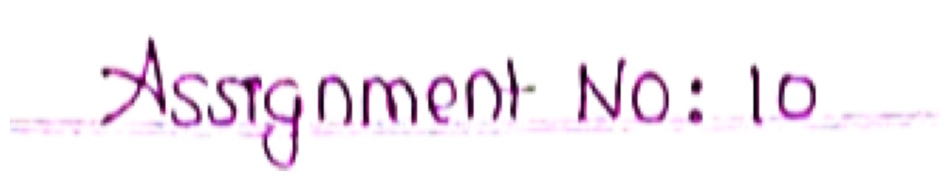

In [93]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image = train_transforms(image)
plt.imshow(image)
plt.axis('off')

In [94]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Assignemnt No: 10


## Initialize the Model


In [95]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

## Model Configurations


In [96]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

We use the AdamW optimizer here with a weight decay of 0.0005.


In [97]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.02
)

## Evaluation Metric


In [98]:
cer_metric = evaluate.load('cer')

In [99]:
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

## Training and Validation Loops


In [100]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='custom_model_handwritten/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [101]:
# Initialize trainer.
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\trocr\processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


## Train


In [102]:
res = trainer.train()

                                                 
  4%|▍         | 39/1040 [10:28<13:07,  1.27it/s] 

{'loss': 5.5572, 'grad_norm': 27.723630905151367, 'learning_rate': 4.524038461538462e-05, 'epoch': 1.0}


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(




                                                 

                                       
  4%|▍         | 39/1040 [10:51<13:07,  1.27it/s] 

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num

{'eval_loss': 4.703540802001953, 'eval_cer': 1.5234567901234568, 'eval_runtime': 22.7354, 'eval_samples_per_second': 1.32, 'eval_steps_per_second': 0.176, 'epoch': 1.0}


KeyboardInterrupt: 

In [29]:
res

TrainOutput(global_step=50, training_loss=5.109059276580811, metrics={'train_runtime': 90.9464, 'train_samples_per_second': 4.398, 'train_steps_per_second': 0.55, 'total_flos': 4.78498749677568e+16, 'train_loss': 5.109059276580811, 'epoch': 10.0})

## Inference


In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [31]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(res.global_step)).to(device)

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [32]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.
    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [33]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.

    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [34]:
def eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'test', '*'),
    num_samples=50
):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_and_show(image_path)
        text = ocr(image, processor, trained_model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

In [35]:
eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'test', '*'),
    num_samples=100
)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
# check on custom images
eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'custom', '*'),
    num_samples=100
)
